In [5]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import time
import joblib
from statistics import median

import pyfinancialdata
import trade_functions
import pandas_techinal_indicators

from envs import SimpleTradingEnvironment
from agent import DQNAgent
from utils import get_scaler

# Auto reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [8]:
# A variable for the name of this notebook
notebook_name = os.path.splitext(os.path.basename(NOTEBOOK_FULL_PATH))[0]

In [9]:
price_data = pyfinancialdata.get_multi_year(
    provider='oanda',
    instrument='GBP_USD',
    years=[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
    time_group='6h',
    price_calculation='close',
)

In [10]:
environment_columns = ['price', 'RSI_14', 'ATR_7', 'ADX_7_14']

def add_features(df):
    '''
    Adds feature columns to a pandas price data df
    '''
    df.reset_index(inplace=True)
    
    df = pandas_techinal_indicators.relative_strength_index(df, 14)
    df = pandas_techinal_indicators.average_true_range(df, 7)
    df = pandas_techinal_indicators.average_directional_movement_index(df, 7, 14)
    
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [11]:
price_data = add_features(price_data.copy())

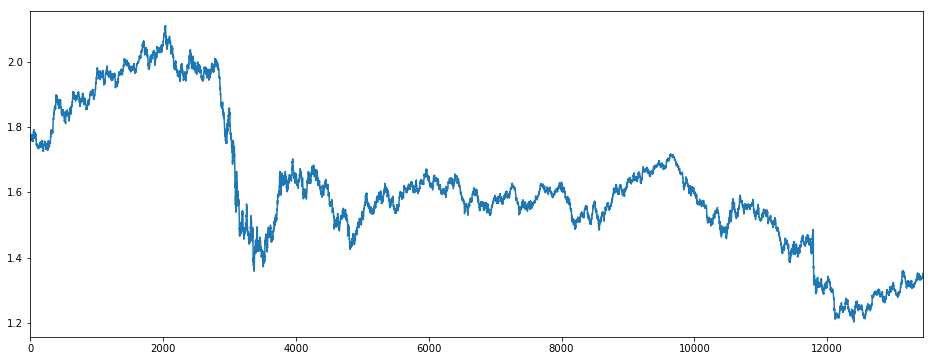

In [12]:
price_data['price'].plot(figsize=(16,6))

In [13]:
train_size = round(len(price_data)/3*2)
train_data = price_data[:train_size].copy()
train_data.reset_index(inplace=True)
test_data = price_data[train_size:].copy()
test_data.reset_index(inplace=True)
print('train size {0}, test size {1}'.format(len(train_data), len(test_data)))

train size 8961, test size 4481


In [14]:
episode=1000
batch_size=10

In [15]:
train_data.head(5)

,index,date,close,high,low,open,price,RSI_14,ATR_7,ADX_7_14
0,0,2006-01-06 12:00:00,1.77105,1.77215,1.75495,1.75555,1.77105,0.801046,0.008815,0.495142
1,1,2006-01-06 18:00:00,1.77060,1.77185,1.76950,1.77115,1.77060,0.801046,0.007195,0.495300
2,2,2006-01-08 18:00:00,1.76910,1.77030,1.76810,1.77030,1.76910,0.753051,0.006019,0.509728
3,3,2006-01-09 00:00:00,1.77210,1.77260,1.76810,1.76920,1.77210,0.778238,0.005639,0.450937
4,4,2006-01-09 06:00:00,1.76565,1.77220,1.76415,1.77200,1.76565,0.647395,0.006242,0.389189


In [16]:
env = SimpleTradingEnvironment(
    price_data=train_data,
    environment_columns=environment_columns,
    debug=False,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
agent = DQNAgent(state_size, action_size)
train_results = pd.DataFrame()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                224       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 1,379
Trainable params: 1,379
Non-trainable params: 0
_________________________________________________________________
None


## Train

In [17]:
for e in range(episode):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(".", end='')
            if (e + 1) % 20 == 0:
                print("")
                print("episode: {0}/{1}".format(e + 1, episode))
                print("median profit: {0} pips, median trade count: {1}".format(
                    round(median(train_results['account_balance'].tolist()) / 0.0001),
                    round(median(train_results['trade_count'].tolist()))
                    )
                )
            train_results = train_results.append(env._stats(), ignore_index=True)
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)



....................
episode: 20/1000
median profit: -847 pips, median trade count: 973
....................
episode: 40/1000
median profit: -183 pips, median trade count: 853
....................
episode: 60/1000
median profit: -65 pips, median trade count: 780
....................
episode: 80/1000
median profit: -65 pips, median trade count: 718
....................
episode: 100/1000
median profit: 384 pips, median trade count: 663
....................
episode: 120/1000
median profit: 583 pips, median trade count: 643
....................
episode: 140/1000
median profit: 1358 pips, median trade count: 633
....................
episode: 160/1000
median profit: 2003 pips, median trade count: 630
....................
episode: 180/1000
median profit: 2216 pips, median trade count: 627
....................
episode: 200/1000
median profit: 2194 pips, median trade count: 627
....................
episode: 220/1000
median profit: 2003 pips, median trade count: 617
....................
episod

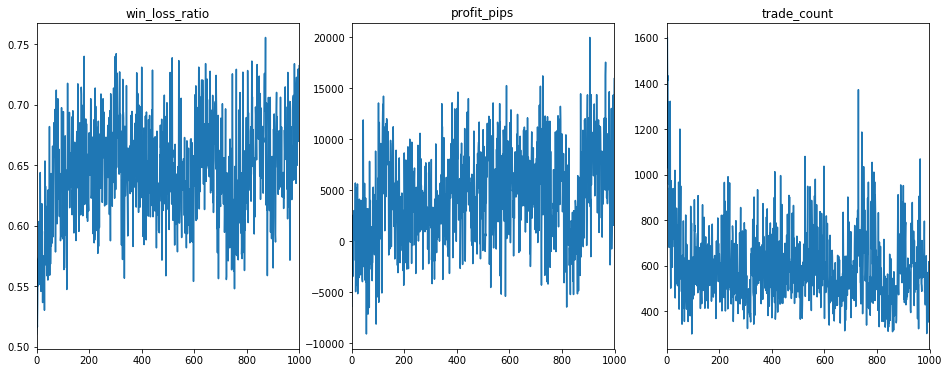

In [18]:
train_results['profit_pips'] = train_results['account_balance'] / 0.0001
columns_to_plot = ['win_loss_ratio', 'profit_pips', 'trade_count']
fig, axes = plt.subplots(nrows=1,ncols=len(columns_to_plot), figsize=(16,6))
for i in range(len(columns_to_plot)):
    axes[i].title.set_text(columns_to_plot[i])
    train_results[columns_to_plot[i]].plot(ax=axes[i], subplots=True)
plt.show()

In [19]:
joblib.dump(agent, '{0}.pkl'.format(notebook_name)) 

['6h-GBP_USD.pkl']

## Test

In [20]:
# Uncomment to load agent from file 
# agent = joblib.load('{0}.pkl'.format(notebook_name))  

In [21]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data,
    environment_columns=environment_columns,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
test_results = pd.DataFrame()

In [22]:
for e in range(1000):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
        if done:
            test_results = test_results.append(env._stats(), ignore_index=True)
            break

In [23]:
test_results['account_balance_pips'] = test_results['account_balance'] / 0.0001
print('Median profit: {0} pips'.format(test_results['account_balance_pips'].median()))

Median profit: 2842.299999999922 pips


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x131c985d0>]],
      dtype=object)

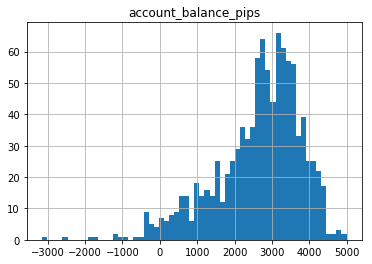

In [24]:
plt.figure(figsize=(16,6))
test_results.hist(column='account_balance_pips', bins=60)

## Analyse positions on test data

In [25]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data.copy(),
    environment_columns=environment_columns,
    save_positions_on_df=True,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n

In [26]:
state = env.reset()
state = scaler.transform([state])
for i in range(env.n_step):
    action = agent.act(state)
    next_state, reward, done = env.step(action)
    next_state = scaler.transform([next_state])
    state = next_state
    if done:
        break

In [27]:
env._stats()

{'trade_count': 194,
 'win_loss_ratio': 0.6443298969072165,
 'account_balance': 0.23402999999999174,
 'unrealised_pl': -0.0005750000000002142}

In [28]:
position_data = env.price_data.copy()

In [29]:
position_data['position'] = position_data['position'] - 1

In [30]:
trades = trade_functions.create_trades_from_positions(position_data.copy())

196 positions to plot...


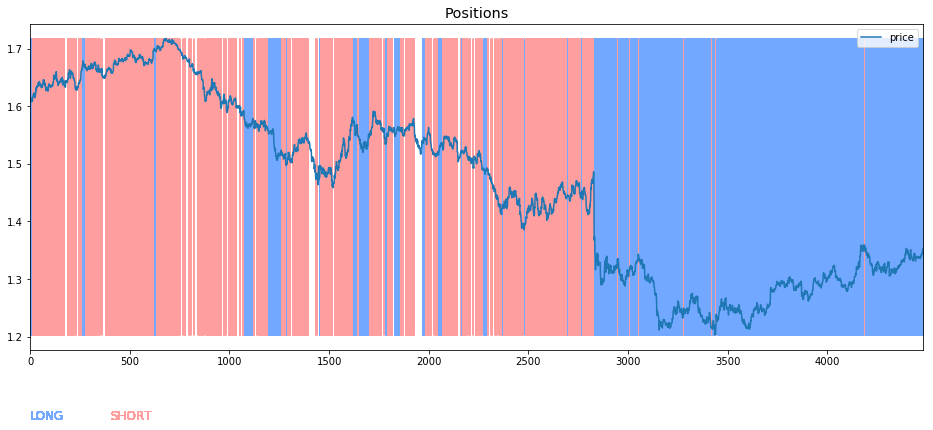

In [31]:
trade_functions.show_positions_on_price_plot(position_data.copy())

In [32]:
trade_functions.get_trade_statistics(trades.copy())

Profitable: 64.29%
Ratio of long to short positions: 0.43
Median profit: 0.0
Total profit: 0.24808000000000074
Median position length: 5.0
Number of trades: 196


In [33]:
trades

,enter_date,enter_price,exit_date,exit_price,position_length,position,profit,profitable,account_balance
0,2013-11-18 06:00:00,1.60995,2013-11-18 12:00:00,1.61017,1,NaN,NaN,False,NaN
1,2013-11-18 12:00:00,1.61017,2013-11-19 18:00:00,1.61359,5,1.0,0.00342,True,0.00342
2,2013-11-20 00:00:00,1.61135,2014-01-13 18:00:00,1.63894,157,-1.0,-0.02759,False,-0.02417
3,2014-01-14 12:00:00,1.64503,2014-01-15 12:00:00,1.63572,4,-1.0,0.00931,True,-0.01486
4,2014-01-20 06:00:00,1.64362,2014-02-02 18:00:00,1.64366,40,-1.0,-0.00004,False,-0.01490
...,...,...,...,...,...,...,...,...,...
191,2017-11-23 12:00:00,1.33054,2017-11-29 12:00:00,1.34283,17,1.0,0.01229,True,0.25222
192,2017-11-29 12:00:00,1.34283,2017-11-29 18:00:00,1.34170,1,-1.0,0.00113,True,0.25335
193,2017-11-29 18:00:00,1.34170,2017-11-30 06:00:00,1.34394,2,1.0,0.00224,True,0.25559
194,2017-11-30 06:00:00,1.34394,2017-11-30 12:00:00,1.35095,1,-1.0,-0.00701,False,0.24858


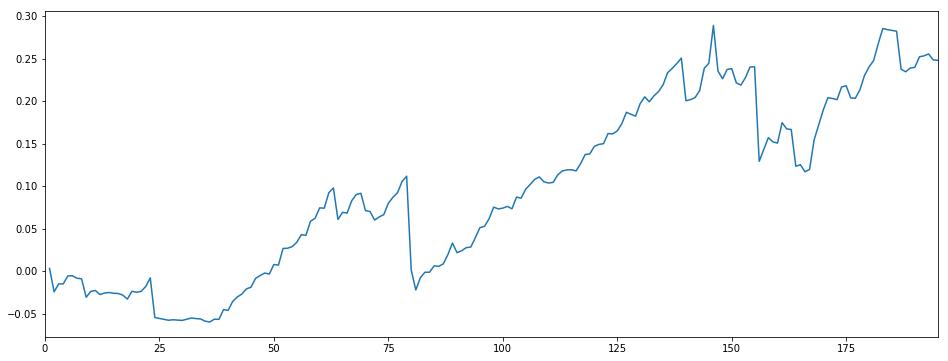

In [34]:
# Plot account balance
trades['account_balance'].plot(figsize=(16,6))

## Show distribution of maximum drawdown

Median drawdown: -0.1843900000000004


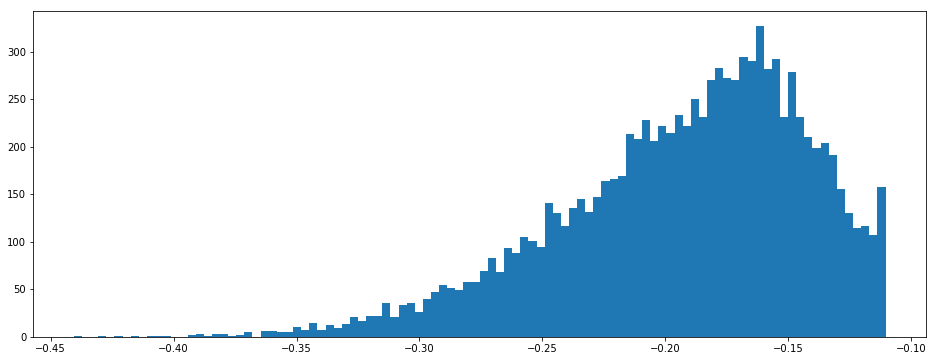

In [35]:
max_drawdown_results = trade_functions.plot_max_drawdown_distribution(trades.copy())
plt.figure(figsize=(16,6))
plt.hist(max_drawdown_results, bins=100);